In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
#RUN

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import random;
import math;
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from torchvision import models
from torch.optim import lr_scheduler
import time

In [0]:
#Read the images and ground_truth from drive

#RUN

Fold_1 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_1.mat')
Fold_2 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_2.mat')
Fold_3 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_3.mat')
Fold_4 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_4.mat')
Fold_5 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_5.mat')

fold_1 = Fold_1['Fold_1']
fold_2 = Fold_2['Fold_2']
fold_3 = Fold_3['Fold_3']
fold_4 = Fold_4['Fold_4']
fold_5 = Fold_5['Fold_5']


In [0]:
#RUN
def get_5_fold(index_4, index_1):
    x = [None]*5
    y = [None]*5
    t = [None]*5
    x[0] = fold_1[:,0]
    x[1] = fold_2[:,0]
    x[2] = fold_3[:,0]
    x[3] = fold_4[:,0]
    x[4] = fold_5[:,0]

    y[0] = fold_1[:,1:(512*512)+ 1]
    y[1] = fold_2[:,1:(512*512)+ 1]
    y[2] = fold_3[:,1:(512*512)+ 1]
    y[3] = fold_4[:,1:(512*512)+ 1]
    y[4] = fold_5[:,1:(512*512)+ 1]

    t[0] = fold_1[:,(512*512)+ 1:2*(512*512)+ 1]
    t[1] = fold_2[:,(512*512)+ 1:2*(512*512)+ 1]
    t[2] = fold_3[:,(512*512)+ 1:2*(512*512)+ 1]
    t[3] = fold_4[:,(512*512)+ 1:2*(512*512)+ 1]
    t[4] = fold_5[:,(512*512)+ 1:2*(512*512)+ 1]

    labels_train = np.concatenate([x[index_4[0]], x[index_4[1]], x[index_4[2]], x[index_4[3]]], 0)
    images_train = np.concatenate([y[index_4[0]], y[index_4[1]], y[index_4[2]], y[index_4[3]]], 0)
    masks_train = np.concatenate([t[index_4[0]], t[index_4[1]], t[index_4[2]], t[index_4[3]]], 0)

    labels_test = x[index_1[0]]
    images_test = y[index_1[0]]
    masks_test = t[index_1[0]]
    del x,y,t
    return labels_train, images_train, masks_train, labels_test, images_test, masks_test

In [5]:
#RUN

# Realize 5-fold cross-validation
from itertools import combinations 
  
# Get all combinations of [1, 2, 3, 4, 5] 
# and length 4
comb = combinations([0, 1, 2, 3, 4], 4) 
comb = list(comb)

#Choose a combination from 0..4
ind = 0
res = [ele  for ele in range(5) if ele   not in comb[ind]] 

#Print first 4-fold indexex for train, and 1-fold index for test
print('Indexes for train: ', comb[ind])
print('Index for test', res)

labels_train, images_train, masks_train, labels_test, images_test, masks_test = get_5_fold(comb[ind], res)
#depend on batch_size


Indexes for train:  (0, 1, 2, 3)
Index for test [4]


In [6]:
#RUN
# Choose l1 and l2 depending on batch_size, and 5_fold generation
# batch should divide de size
# Here I hard coded the values for train and test, depending on folders that I have selected for train and test
l = [[2400, 630], [2430, 600], [2460, 570], [2370, 630], [2490, 540]]
l1 = [[1650, 450]]

CHOOSE = l

size_train_loader = CHOOSE[ind][0]
size_test_loader = CHOOSE[ind][1]

labels_train = labels_train[0:size_train_loader]
images_train = images_train[0:size_train_loader, :]
masks_train = masks_train[0:size_train_loader, :]

labels_test = labels_test[0:size_test_loader]
images_test = images_test[0:size_test_loader, :]
masks_test = masks_test[0:size_test_loader, :]

print(labels_train.shape, images_train.shape, masks_train.shape)
print(labels_test.shape, images_test.shape, masks_test.shape)



(2400,) (2400, 262144) (2400, 262144)
(630,) (630, 262144) (630, 262144)


In [0]:
#RUN to permute data
from sklearn.utils import shuffle

shuffle_labels_train, shuffle_images_train, shuffle_mask_train = shuffle(labels_train, images_train, masks_train, random_state=0)
shuffle_labels_test, shuffle_images_test, shuffle_mask_test = shuffle(labels_test, images_test, masks_test, random_state=0)



In [9]:
print(shuffle_labels_train.shape, shuffle_images_train.shape, shuffle_mask_train.shape)


(2400,) (2400, 262144) (2400, 262144)


In [0]:
#RUN
#free RAM, because session will crash
%reset_selective -f Fold_1
%reset_selective -f Fold_2
%reset_selective -f Fold_3
%reset_selective -f Fold_4
%reset_selective -f Fold_5

In [10]:
# Count the number of unique labels in fold
unique, counts = np.unique(shuffle_labels_train, return_counts=True)
uniquee, countss = np.unique(shuffle_labels_test, return_counts=True)
print(counts, countss)


[ 542 1133  725] [165 275 190]


In [0]:
shuffle_labels_train = torch.from_numpy(shuffle_labels_train)
shuffle_images_train = torch.from_numpy(shuffle_images_train)
shuffle_mask_train = torch.from_numpy(shuffle_mask_train)

shuffle_labels_test = torch.from_numpy(shuffle_labels_test)
shuffle_images_test = torch.from_numpy(shuffle_images_test)
shuffle_mask_test = torch.from_numpy(shuffle_mask_test)

In [12]:
#Compute mean and std dev for train set

mean_tr = (shuffle_images_train.float().mean())
std_tr = (shuffle_images_train.float().std())
print(mean_tr, std_tr)

tensor(466.2386) tensor(644.9455)


In [0]:
class BrainDataset(Dataset):
    '''Brain Dataset'''
    def __init__(self, t_x, t_m, t_y, ratio, size, mean, std, transform=None):
        self.X         = t_x
        self.Y         = t_y
        self.M         = t_m
        self.ratio     = ratio
        self.size      = size
        self.transform = transform
        self.mean      = mean
        self.std       = std
    def __len__(self):
        return len(self.X);
      
    def transformm(self, image, mask):

        # Random horizontal flipping
        image = transforms.ToPILImage()(image)
        mask = transforms.ToPILImage()(mask)
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
            
        if random.random() > 0.5:
            rotation = random.randint(15, 45)
            image = TF.rotate(image, rotation)
            mask = TF.rotate(mask, rotation)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        mask = self.M[idx]
        #imaginea 512x512 o transform in size x size
        #image 512x512 will become 512/ratio x 512//ratio for optimize memory
        
        item = item.view(-1, 512)
        item = item[0:512:self.ratio,0:512:self.ratio]
                
        mask = mask.view(-1, 512)
        mask = mask[0:512:self.ratio,0:512:self.ratio]
        
        item = item.float()
        
        if self.transform == 1:   
          item, mask = self.transformm(np.float32(item.view(-1, self.size)), np.float32(mask.view(-1, self.size)))
        else:
          mask = transforms.ToPILImage()(np.float32(mask.view(-1, self.size)))
          item = transforms.ToPILImage()(np.float32(item.view(-1, self.size)))
          mask = TF.to_tensor(mask)
          item = TF.to_tensor(item)
        return (item, mask, label)

In [0]:
#RUN
batch_size = 30
ratio = 4 #how much we reduce from 1 dimension of image. Ex. ratio = 2 => 256x256 image , ratio = 4 => 512x512
size_image = 128 #Dimmension by dividing height and weight to ratio

train_dataset = BrainDataset(shuffle_images_train, shuffle_mask_train, shuffle_labels_train, ratio, size_image, mean_tr, std_tr, transform = 0)
test_dataset = BrainDataset(shuffle_images_test, shuffle_mask_test, shuffle_labels_test, ratio, size_image, mean_tr, std_tr, transform = 0)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           );
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          );
##########




2400
tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  4.,  3.,  1.],
         [ 6.,  9., 10.,  ..., 21., 18., 13.],
         ...,
         [16., 26., 28.,  ..., 27., 33., 23.],
         [ 6.,  9.,  6.,  ..., 21., 18., 13.],
         [ 0.,  0.,  0.,  ...,  8.,  6.,  5.]]])
tensor(2, dtype=torch.int16)


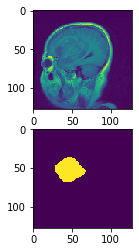

630


In [21]:
#RUN to test if data is normalized, and mask is correlated with image
#Printez sa vad daca s-a normalizat
#Print values from an image to see if values are normalized
print(train_dataset.__len__())
t, m, l = train_dataset.__getitem__(0)
#print(t[0][100])
print(t)
print(l)

plt.figure(1)
plt.subplot(211)
plt.imshow(t[0])

plt.subplot(212)
plt.imshow(m[0])
plt.show()

print(test_dataset.__len__())

In [15]:
# Library to extract GLCM, GLRLM features from image

%pip install pyradiomics

In [0]:
from radiomics import firstorder, glcm, imageoperations, shape, glrlm, glszm, getTestCase
import SimpleITK as sitk
import six
import sys, os

In [17]:
#Extract GLCM features

feature_per_image =  np.zeros(shape=(25))
feature_train_glcm = np.zeros(shape=(train_dataset.__len__(), 25))
feature_test_glcm  = np.zeros(shape=(test_dataset.__len__(), 25))

for i in range(0, train_dataset.__len__()):
  im, ma, label = train_dataset.__getitem__(i)
  image = sitk.GetImageFromArray(im)
  mask = sitk.GetImageFromArray(ma)
  firstOrderFeatures = glcm.RadiomicsGLCM(image,mask)
  firstOrderFeatures.enableAllFeatures()  # On the feature class level, all features are disabled by default.
  firstOrderFeatures.execute()
  feature_per_image[0] = label
  
  j = 1
  for (key,val) in six.iteritems(firstOrderFeatures.featureValues):
    feature_per_image[j] = val
    j += 1

  feature_train_glcm[i] = feature_per_image

for i in range(0, test_dataset.__len__()):
  im, ma, label = test_dataset.__getitem__(i)
  image = sitk.GetImageFromArray(im)
  mask = sitk.GetImageFromArray(ma)
  firstOrderFeatures = glcm.RadiomicsGLCM(image,mask)
  firstOrderFeatures.enableAllFeatures()  # On the feature class level, all features are disabled by default.
  firstOrderFeatures.execute()
  feature_per_image[0] = label
  
  j = 1
  for (key,val) in six.iteritems(firstOrderFeatures.featureValues):
    feature_per_image[j] = val
    j += 1

  feature_test_glcm[i] = feature_per_image

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [18]:
#Extract GLRLM features

feature_per_image =  np.zeros(shape=(17))
feature_train_glrlm = np.zeros(shape=(train_dataset.__len__(), 17))
feature_test_glrlm  = np.zeros(shape=(test_dataset.__len__(), 17))

for i in range(0, train_dataset.__len__()):
  im, ma, label = train_dataset.__getitem__(i)
  image = sitk.GetImageFromArray(im)
  mask = sitk.GetImageFromArray(ma)
  firstOrderFeatures = glrlm.RadiomicsGLRLM(image,mask)
  firstOrderFeatures.enableAllFeatures()  # On the feature class level, all features are disabled by default.
  firstOrderFeatures.execute()
  feature_per_image[0] = label
  
  j = 1
  for (key,val) in six.iteritems(firstOrderFeatures.featureValues):
    feature_per_image[j] = val
    j += 1

  feature_train_glrlm[i] = feature_per_image

for i in range(0, test_dataset.__len__()):
  im, ma, label = test_dataset.__getitem__(i)
  image = sitk.GetImageFromArray(im)
  mask = sitk.GetImageFromArray(ma)
  firstOrderFeatures = glrlm.RadiomicsGLRLM(image,mask)
  firstOrderFeatures.enableAllFeatures()  # On the feature class level, all features are disabled by default.
  firstOrderFeatures.execute()
  feature_per_image[0] = label
  
  j = 1
  for (key,val) in six.iteritems(firstOrderFeatures.featureValues):
    feature_per_image[j] = val
    j += 1

  feature_test_glrlm[i] = feature_per_image


print(feature_test_glrlm[0][0])


3.0


In [0]:
# Concatenate GLCM and GLRLM features

feature_train_glcm_glrlm = np.concatenate((feature_train_glcm , feature_train_glrlm[:, 1:] ), axis = 1)
feature_test_glcm_glrlm = np.concatenate((feature_test_glcm , feature_test_glrlm[:, 1:] ), axis = 1)



In [0]:

class GetFeatures:
    '''Brain Dataset'''
    def __init__(self, train, test, mode):
        self.Train  = train
        self.Test   = test
        self.mode   = mode
      
    def __len__(self):
        return len(self.X);
    
    def train_test_set(self):
      if self.mode == 'extract':
        X_train = self.Train[:, 1:]
        Y_train = self.Train[:, 0]
        X_test  = self.Test[:, 1:]
        Y_test  = self.Test[:, 0]
      else:
        X_train = []
        Y_train = []
        X_test  = []
        Y_test  = []

        for i in range(0, train_dataset.__len__()):
            im, ma, label = train_dataset.__getitem__(i)
            im = (im - mean_tr)/std_tr

            X_train.append(im)
            Y_train.append(label)
        for i in range(0, test_dataset.__len__()):
            im, ma, label = test_dataset.__getitem__(i)
            X_test.append(im)
            Y_test.append(label)

        X_train = [t.numpy() for t in X_train]
        Y_train = [t.numpy() for t in Y_train]
        X_test  = [t.numpy() for t in X_test]
        Y_test  = [t.numpy() for t in Y_test]

        X_train = np.asarray(X_train)
        Y_train = np.asarray(Y_train)
        X_test = np.asarray(X_test)
        Y_test = np.asarray(Y_test)

        X_train = np.reshape(X_train, (-1, 128*128))
        X_test  = np.reshape(X_test, (-1, 128*128))
        

      return (X_train, Y_train, X_test, Y_test)

In [0]:
# Train SVM using GLCM, GRLRLM, or both 

getFeatures = GetFeatures(feature_train_glcm, feature_test_glcm, 'extract')
# getFeatures = GetFeatures(feature_train_glrlm, feature_test_glrlm)
# getFeatures = GetFeatures(feature_train_glcm_glrlm, feature_test_glcm_glrlm)

X_train, Y_train, X_test, Y_test = getFeatures.train_test_set()

from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)

X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [0]:
# Train SVM using pixels from image

getFeatures = GetFeatures(feature_train_glcm, feature_test_glcm, 'no')
X_train, Y_train, X_test, Y_test = getFeatures.train_test_set()

In [30]:
print(X_train.shape)
print(Y_train.shape)



(2400, 16384)
(2400,)


In [23]:
from sklearn.svm import SVC,LinearSVC
C_param = 100
svm_model = SVC(C_param, kernel='linear',  decision_function_shape='ovr',  class_weight='balanced')
svm_model.fit(X_train, Y_train)

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [24]:
import collections

y_pred_test = svm_model.predict(X_test)
y_pred = svm_model.predict(X_train)


y_true = Y_train
y_true_test = Y_test
from sklearn.metrics import accuracy_score
print(collections.Counter(y_true))
print(collections.Counter(y_pred))

print(accuracy_score(y_true, y_pred))
print(accuracy_score(y_true_test, y_pred_test))


Counter({2.0: 1133, 3.0: 725, 1.0: 542})
Counter({2.0: 1042, 3.0: 740, 1.0: 618})
0.7808333333333334
0.7666666666666667


In [0]:
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import classification_report, precision_score, accuracy_score, make_scorer

scorer1 = make_scorer(precision_score, average = 'weigh9ted')
scorer2 = make_scorer(accuracy_score)

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
scores =[scorer2]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, scoring= score)
    clf.fit(X_train, Y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    # for params, mean_score, scores in clf.cv_results_:
    #     print("%0.3f (+/-%0.03f) for %r"
    #           % (mean_score, scores.std() / 2, params))
    # print(clf.cv_results_.keys())
    for i in ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score']:
        print(i," : ",clf.cv_results_[i])
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = Y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
